<a href="https://colab.research.google.com/github/fahmiad/CNN-ChiliLeafDisease/blob/main/klasifikasi_cabe_alexnet_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###menyambungkan gdrive ke colab

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


###import dataset

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

images = []
label = []
import os
for dirname, _, filenames in os.walk('/content/gdrive/MyDrive/Colab Notebooks/dataset/'):
    for filename in filenames:
        images.append(os.path.join(filename).split('/')[-1])
        label.append(os.path.join(dirname).split('/')[-1])

###import library yang akan digunakan

In [ ]:
import torch
import torchvision
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms as T
from PIL import Image
import random
import time
from tqdm.notebook import tqdm
from torch.nn import functional as F
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

###memperlihatkan dataset dan label

In [ ]:
IMAGE = '/content/gdrive/MyDrive/Colab Notebooks/dataset/'
TARGET_LABEL = {'keriting': 0,
                'kuning': 1,
                'sehat': 2,
                'leafspot': 3,
                'whitefly': 4}

df = pd.DataFrame({'image':images, 'label': label})
df

,image,label
0,download (39) dhennyy.jpg,keriting
1,download (55) dhennyy.jpg,keriting
2,download (15) dhenny.jpg,keriting
3,download (17) dhennyy.jpg,keriting
4,download (35) dhennyy.jpg,keriting
...,...,...
995,leaf spot01 (5) (Ahmad).jpg,leafspot
996,leaf spot01 (10) (Ahmad).jpg,leafspot
997,leaf spot01 (8) (Ahmad).jpg,leafspot
998,leaf spot01 (2) (Ahmad).jpg,leafspot


###menunjukkan presentase sebaran data

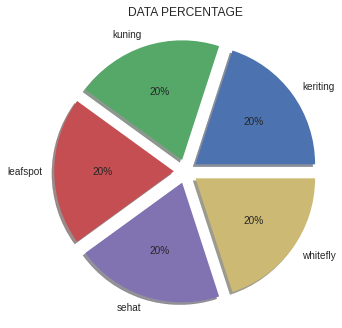

In [ ]:
label, count = np.unique(df['label'].values, return_counts=True)
precentange = [x / np.sum(count) for x in count]
plt.style.use('seaborn')
plt.pie(precentange, labels = label, explode=[0.1, 0.1, 0.1, 0.1, 0.1],  autopct='%1.f%%', shadow=True)
plt.title('DATA PERCENTAGE')
plt.show()

###mempersiapkan fungsi untuk memuat dataset

In [ ]:
class Penyakit(Dataset):
    def __init__(self, x, y, path, map_label=TARGET_LABEL, transform=None):
        self.X = x
        self.y = y
        self.path = path
        self.map_label = map_label
        self.transform = transform

    def __getitem__(self, idx):
        img = Image.open(self.path + str(self.y[idx]) + '/' + str(self.X[idx])).convert('RGB')
        label = self.map_label[self.y[idx]]

        if self.transform is not None:
            img = self.transform(img)

        return img, label

    def __len__(self):
        return len(self.X)

X_trainval, X_test, y_trainval, y_test = train_test_split(
    df['image'].values, df['label'].values,
    test_size=0.15, stratify=df['label'].values,
    random_state=77)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    stratify=y_trainval, test_size=0.15,
    random_state=77)
len(X_train), len(X_val), len(X_test)

(722, 128, 150)

###memuat dataset

In [ ]:
#DATALOADER
mean = [0.5548598 , 0.54704523, 0.54043627]
std = [0.1071739 , 0.10524916, 0.10435305]
batch_size = 16

train_transform = T.Compose([T.Resize((128, 128)),
                             T.RandomHorizontalFlip(),
                             T.RandomVerticalFlip(),
                             T.RandomRotation(20),
                             T.ToTensor(),
                             T.Normalize(mean, std)
                            ])

val_transform = T.Compose([T.Resize((128, 128)),
                           T.ToTensor(),
                           T.Normalize(mean, std),
                          ])

train_set = Penyakit(X_train, y_train, IMAGE, transform=train_transform)
val_set = Penyakit(X_val, y_val, IMAGE, transform=val_transform)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
                                           num_workers=0, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=batch_size*2, shuffle=False,
                                         num_workers=0, pin_memory=True)

###menunjukkan isi dari data training secara random

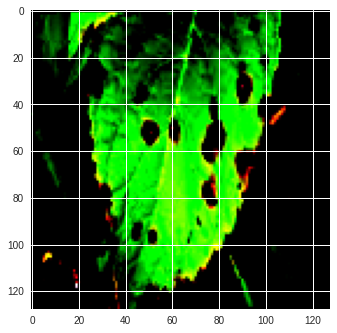

In [ ]:
img, label = train_set[random.randint(0, len(X_train))]

plt.imshow(img.permute(1,2,0))

###memuat model resnet
memuat resnet dengan 512 Neuron dan 3 class

In [ ]:
model = torchvision.models.alexnet(pretrained=True)
model.fc = nn.Linear(in_features=512, out_features=5, bias=True)
#model.classifier[6] = nn.Linear(4096, 20)
model

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

###menyiapkan fungsi untuk menampung data akurasi dari proses training

akurasi = jumlah prediksi benar : jumlah total melakukan prediksi

In [ ]:
def accuracy(output, label):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, label).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

epoch = 32
lr = 2e-4
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=epoch,
                                               steps_per_epoch=len(train_loader))

###proses training model neural network

In [ ]:
train_losses = []
val_losses =[]
train_accuracy = []
val_acc = []
times = []
for e in range(epoch):
    model.to(device)
    model.train()

    train_loss = 0
    train_acc = 0
    since = time.time()
    for image, label in tqdm(train_loader, total=len(train_loader)):
        optimizer.zero_grad()

        image = image.to(device)
        label = label.to(device)
        output = model(image)
        loss = criterion(output, label)

        train_loss += loss
        train_acc += accuracy(output, label)

        loss.backward()
        optimizer.step()
        scheduler.step()

    else:
        with torch.no_grad():
            model.eval()

            running_loss = 0
            val_accuracy =0
            for image, label in val_loader:
                image = image.to(device)
                label = label.to(device)

                output = model(image)
                loss = criterion(output, label)
                val_accuracy += accuracy(output, label)
                running_loss += loss

    train_losses.append((train_loss/len(train_loader)).item())
    val_losses.append((running_loss/len(val_loader)).item())
    train_accuracy.append(train_acc/ len(train_loader))
    val_acc.append(val_accuracy/len(val_loader))

    times.append(time.time() - since)

    print('epochs {}/{}..'.format(e+1, epoch),
          'train loss {:.3f}..'.format(train_loss/len(train_loader)),
          'val loss {:.3f}..'.format(running_loss/len(val_loader)),
          'train accuracy {:.3f}..'.format(train_acc/ len(train_loader)),
          'val accuracy {:.3f}..'.format(val_accuracy/len(val_loader)),
          'time {:.3f} s'.format(time.time() - since)
         )

print(sum(times))

  0%|          | 0/46 [00:00<?, ?it/s]

epochs 1/32.. train loss 13.201.. val loss 7.167.. train accuracy 0.016.. val accuracy 0.023.. time 256.657 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 2/32.. train loss 3.643.. val loss 2.480.. train accuracy 0.234.. val accuracy 0.297.. time 45.941 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 3/32.. train loss 1.528.. val loss 1.525.. train accuracy 0.482.. val accuracy 0.484.. time 45.931 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 4/32.. train loss 1.043.. val loss 1.180.. train accuracy 0.594.. val accuracy 0.570.. time 46.020 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 5/32.. train loss 0.899.. val loss 0.923.. train accuracy 0.679.. val accuracy 0.680.. time 46.047 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 6/32.. train loss 0.752.. val loss 0.733.. train accuracy 0.724.. val accuracy 0.773.. time 45.989 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 7/32.. train loss 0.717.. val loss 0.695.. train accuracy 0.747.. val accuracy 0.750.. time 46.042 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 8/32.. train loss 0.657.. val loss 0.827.. train accuracy 0.765.. val accuracy 0.703.. time 45.930 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 9/32.. train loss 0.677.. val loss 0.766.. train accuracy 0.766.. val accuracy 0.734.. time 46.202 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 10/32.. train loss 0.615.. val loss 0.645.. train accuracy 0.779.. val accuracy 0.750.. time 46.104 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 11/32.. train loss 0.587.. val loss 0.756.. train accuracy 0.779.. val accuracy 0.734.. time 46.169 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 12/32.. train loss 0.520.. val loss 0.531.. train accuracy 0.810.. val accuracy 0.758.. time 46.055 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 13/32.. train loss 0.401.. val loss 0.447.. train accuracy 0.849.. val accuracy 0.844.. time 46.161 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 14/32.. train loss 0.337.. val loss 0.380.. train accuracy 0.882.. val accuracy 0.844.. time 46.247 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 15/32.. train loss 0.314.. val loss 0.589.. train accuracy 0.890.. val accuracy 0.758.. time 46.363 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 16/32.. train loss 0.345.. val loss 0.565.. train accuracy 0.887.. val accuracy 0.820.. time 46.138 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 17/32.. train loss 0.316.. val loss 0.372.. train accuracy 0.887.. val accuracy 0.875.. time 46.257 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 18/32.. train loss 0.318.. val loss 0.255.. train accuracy 0.894.. val accuracy 0.914.. time 46.351 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 19/32.. train loss 0.223.. val loss 0.220.. train accuracy 0.921.. val accuracy 0.922.. time 46.528 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 20/32.. train loss 0.193.. val loss 0.270.. train accuracy 0.916.. val accuracy 0.922.. time 46.671 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 21/32.. train loss 0.149.. val loss 0.316.. train accuracy 0.938.. val accuracy 0.883.. time 46.776 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 22/32.. train loss 0.140.. val loss 0.364.. train accuracy 0.951.. val accuracy 0.883.. time 47.145 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 23/32.. train loss 0.136.. val loss 0.325.. train accuracy 0.950.. val accuracy 0.906.. time 47.924 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 24/32.. train loss 0.136.. val loss 0.357.. train accuracy 0.943.. val accuracy 0.914.. time 47.838 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 25/32.. train loss 0.110.. val loss 0.276.. train accuracy 0.959.. val accuracy 0.938.. time 47.751 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 26/32.. train loss 0.116.. val loss 0.264.. train accuracy 0.952.. val accuracy 0.914.. time 48.292 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 27/32.. train loss 0.100.. val loss 0.244.. train accuracy 0.966.. val accuracy 0.922.. time 48.520 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 28/32.. train loss 0.094.. val loss 0.241.. train accuracy 0.958.. val accuracy 0.914.. time 48.712 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 29/32.. train loss 0.092.. val loss 0.244.. train accuracy 0.954.. val accuracy 0.906.. time 49.210 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 30/32.. train loss 0.095.. val loss 0.249.. train accuracy 0.965.. val accuracy 0.914.. time 49.374 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 31/32.. train loss 0.074.. val loss 0.252.. train accuracy 0.966.. val accuracy 0.922.. time 48.892 s


  0%|          | 0/46 [00:00<?, ?it/s]

epochs 32/32.. train loss 0.100.. val loss 0.252.. train accuracy 0.958.. val accuracy 0.922.. time 48.948 s
1713.1888501644135


In [ ]:
time_str = float(sum(times))
print('total waktu {:.3f} s'.format(time_str))
# print(time_str)

total waktu 1713.189 s


###menampilkan grafik akurasi menggunakan matplotlib

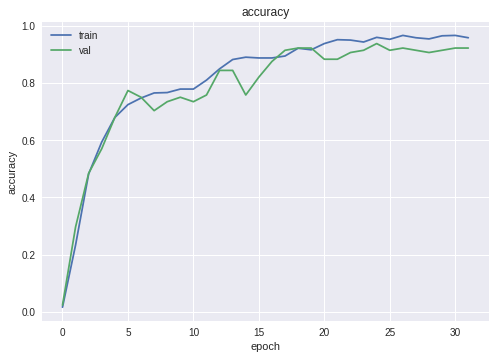

In [ ]:
plt.plot(train_accuracy, label='train')
plt.title('accuracy')
plt.ylabel('accuracy'); plt.xlabel('epoch')
plt.plot(val_acc, label='val')
plt.legend()
plt.show()

###menampilkan grafik loss menggunakan matplotlib

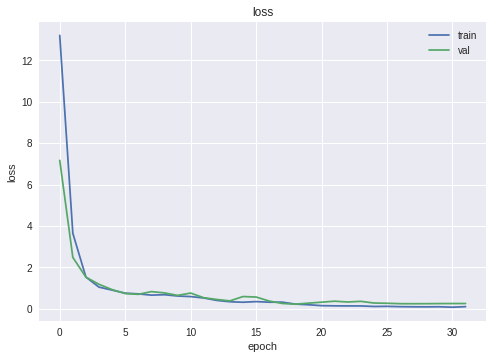

In [ ]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.title('loss')
plt.ylabel('loss'); plt.xlabel('epoch')
plt.legend()
plt.show()

###proses pengujian data

In [ ]:
test_set = Penyakit(X_test, y_test, IMAGE, transform=val_transform)

def predict(model, img, label):
    model.eval()
    with torch.no_grad():
        img = img.unsqueeze(0).to(device)
        output = model(img)
        pred = torch.argmax(F.softmax(output, dim=1)).cpu().item()
    return pred

test_predict = []
true_label = []
for i in range(len(test_set)):
    img, label = test_set[i]
    prediction = predict(model, img, label)
    test_predict.append(prediction)
    true_label.append(label)

###menampilkan hasil pengujian data secara acak

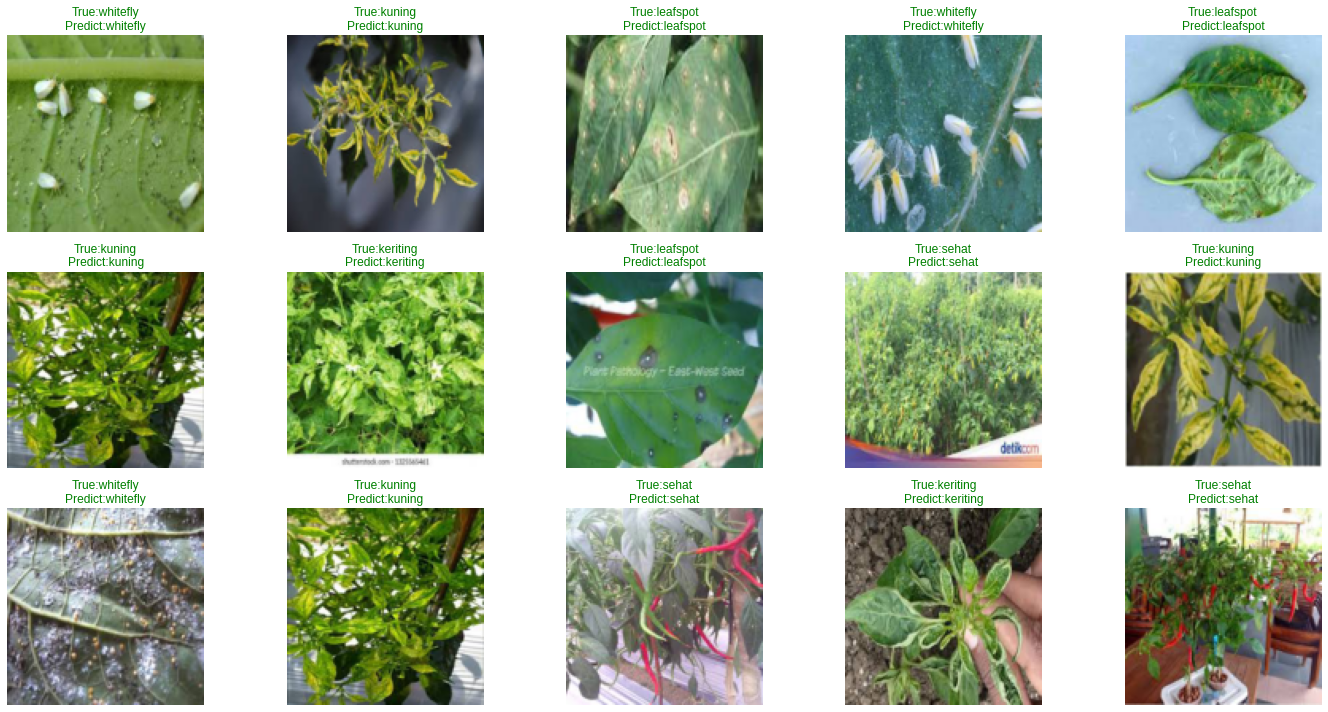

In [ ]:
ints_2_label = {0: 'keriting',
                1: 'kuning',
                2: 'sehat',
                3: 'leafspot',
                4: 'whitefly'}

random_selection = np.random.randint(0, len(test_predict), 15)

fig = plt.figure(figsize=(20, 10))

test_set = Penyakit(X_test, y_test, IMAGE, transform=T.Resize((124,124)))
for i, idx in enumerate(random_selection):
    image, label = test_set[idx]
    ax = fig.add_subplot(3, 5, i+1, xticks=[], yticks = [])
    ax.imshow(image)
    ax.set_title('True:{}\nPredict:{}'.format(ints_2_label[label], ints_2_label[test_predict[idx]]),
                color=("green" if label == test_predict[idx] else 'red'), fontsize=12)

plt.tight_layout() #want faster comment or delete this
plt.show()

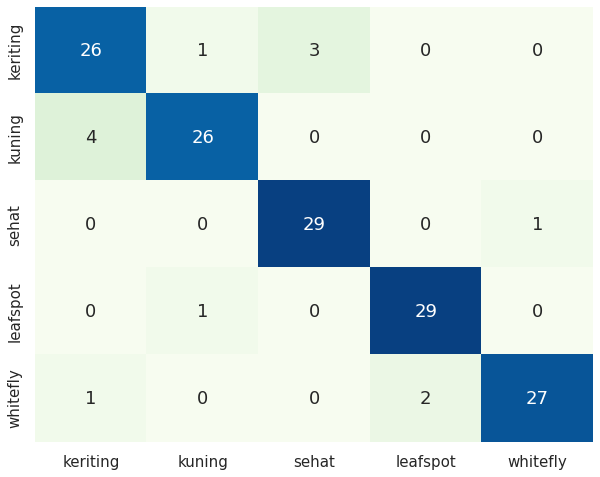

In [ ]:
plt.figure(figsize=(10,8))
sns.set(font_scale=1.5) # Adjust to fit
sns.heatmap(confusion_matrix(true_label, test_predict), annot=True, cmap='GnBu', cbar=False)
plt.tick_params(axis='both', which='major', labelsize=15)  # Adjust to fit

plt.xticks(ticks=np.arange(0.5, len(list(TARGET_LABEL.keys()))), labels = list(TARGET_LABEL.keys()))
plt.yticks(ticks=np.arange(0.5, len(list(TARGET_LABEL.keys()))), labels = list(TARGET_LABEL.keys()))
plt.show()

In [ ]:
print(classification_report(true_label, test_predict))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85        30
           1       0.93      0.87      0.90        30
           2       0.91      0.97      0.94        30
           3       0.94      0.97      0.95        30
           4       0.96      0.90      0.93        30

    accuracy                           0.91       150
   macro avg       0.91      0.91      0.91       150
weighted avg       0.91      0.91      0.91       150

